# <div align="center">ĐỒ ÁN NHẬP MÔN KHOA HỌC DỮ LIỆU</div>

#### Thành viên
* Trần Đức Thắng - 1712761
* Lê Quang Quí - 1712710 

-------

## <div align="center"> XÂY DỰNG MÔ HÌNH ĐÁNH GIÁ ĐIỆN THOẠI QUA BÌNH LUẬN CỦA TRANG THEGIOIDIDONG.COM</div>

## I. Dữ Liệu

Dữ liệu được crawl trực tiếp từ trang [Thế Giới Di Động](https://www.thegioididong.com/) bao gồm tất cả **comment** (nhận xét) và **số sao** (biểu trưng mức độ hài lòng về sản phẩm) của điện thoại.

Sau quá trình crawl dữ liệu, thu được **5 file text** dự theo số sao của comment:
* **comment1.txt** : Comment có đánh giá **1 sao**
* **comment2.txt** : Comment có đánh giá **2 sao**
* **comment3.txt** : Comment có đánh giá **3 sao**
* **comment4.txt** : Comment có đánh giá **4 sao**
* **comment5.txt** : Comment có đánh giá **5 sao**

## II. Khám Phá Dữ Liệu

#### 1. Import một số thư viện cần thiết

In [1]:
#!pip install underthesea

In [2]:
import numpy as np
import pandas as pd
import re
from underthesea import word_tokenize
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.externals import joblib
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

#### 2. Đọc dữ liệu và lưu vào dataframe

*Do trong các comment đôi khi có dấu xuống dòng ("\n") vì vậy nếu đọc file theo các thông thường từ các thư viện của pandas sẽ dẫn đến dữ liệu sai và thiếu, vì vậy cần viết hàm đọc file mới.*

In [3]:
# load data
def load_data_model(filepath, n, star):
    data = []
    with open(filepath, encoding="utf8") as fp:
        line = fp.readline()
        if line.strip().split(':')[0] == 'Name':
            name = line.strip().split(':')[1]
            temp = ''
        cnt = 1
        while line:
            #print("Line {}: {}".format(cnt, line.strip()))
            if line.strip().split(':')[0] == 'Name':
                name = line.strip().split(': ')[1]
                line = fp.readline()
            elif line.strip() == '':
                data.append([name, temp, n, star])
                temp = ''
            else:
                temp += ' ' + line.strip()
            line = fp.readline()
    return pd.DataFrame(data, columns=['model', 'Text', 'Sentiment', 'Star'])

In [4]:
data1 = load_data_model('comment1.txt', 0, 1)
data2 = load_data_model('comment2.txt', 0, 2)
data3 = load_data_model('comment3.txt', 1, 3)
data4 = load_data_model('comment4.txt', 1, 4)
data5 = load_data_model('comment5.txt', 1, 5)
df = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

pd.set_option('display.max_colwidth',1000)

df.head(3)

,model,Text,Sentiment,Star
0,Samsung Galaxy A71,"Dùng được 1 tháng thì sạc đến 95% là không lên nữa. Rút sạc ra cắm lại thì 100%, khônng hiểu.",0,1
1,Samsung Galaxy A71,Trời ơi làm ơn cho đổi máy khác đi mua mấy tháng giờ lỗi phần đánh thức buồn kg trôi.đưa đi kiểm tra rồi về vẫn bị a71 .là vậy sao làm ơn đôi máy khác đi,0,1
2,Samsung Galaxy A71,"Máy mua mới từ tháng 5/2020 Dùng được 3 tháng thì cắm sạc không vào ( điện thoại không rơi vào nước, không để nước vào ) Mang ra bảo hành thì báo lỗi cá nhân không được bảo hành thay mất 800k.",0,1


#### 3. Thông tin thuộc tính

In [5]:
num_rows, num_cols = df.shape
print("Dữ liệu có {} dòng, {} cột.".format(num_rows, num_cols))

Dữ liệu có 18018 dòng, 4 cột.


* model : Tên điện thoại
* Text : Nhận xét về điện thoại
* Sentiment : Đánh giá (tốt/xấu)
* Star : Số sao

## III. Đặt Câu Hỏi

**1. Top 10 điện thoại có nhiều comment nhất? Top 10 điện thoại có ít comment nhất?**

**2. Số lượng comment trung bình trên 1 điện thoại?**

**3. Tỉ lệ tương quan giữa mức độ hài lòng của các comment?**

## IV. Trả Lời Câu Hỏi

#### 1. Top 10 điện thoại có nhiều comment nhất?

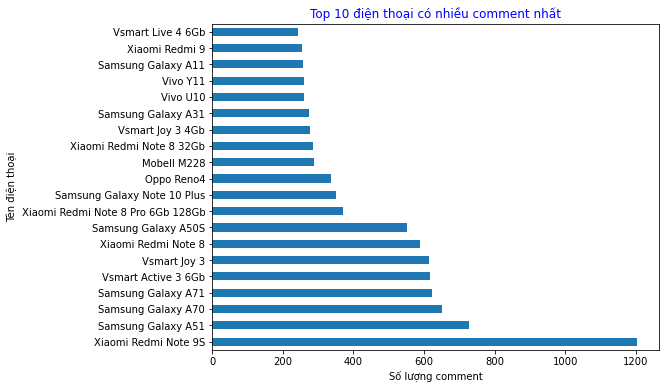

In [6]:
totalCommentCount = df.model.value_counts()
mostComment = totalCommentCount.head(20)
plt.figure(figsize=(8, 6))
plt.xlabel("Số lượng comment")
plt.ylabel("Tên điện thoại")
plt.title('Top 10 điện thoại có nhiều comment nhất', color = 'blue')
mostComment.plot.barh()
plt.show()

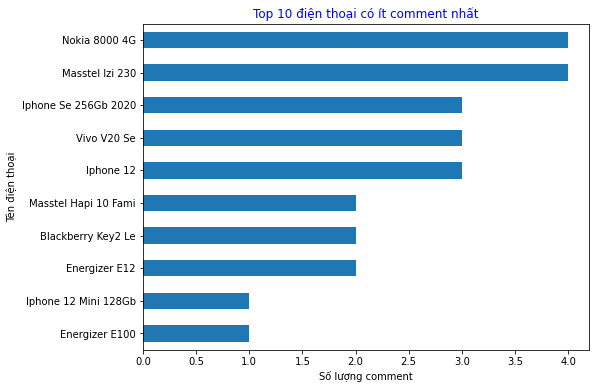

In [7]:
# Số lượng comment của từng điện thoại
totalCommentCount = df.model.value_counts()
lessComment = totalCommentCount[::-1].head(10)
plt.figure(figsize=(8, 6))
plt.xlabel("Số lượng comment")
plt.ylabel("Tên điện thoại")
plt.title('Top 10 điện thoại có ít comment nhất'
          ,color = 'blue')
lessComment.plot.barh()
plt.show()

Như ta thấy sự chênh số lượng comment ở các điện thoại là rất lớn, với max là 1200 commnent và min là 1 comment, từ đó đánh giá được sự bộ dữ liệu đầu vào là có sự chênh lệch lớn

==> vì vậy để chọn được tập test có thể đánh giá được mô hình học thì nên ưa tiên các dòng điện thoại có nhiều comment 

#### 2. Số lượng comment trung bình trên 1 điện thoại?

In [8]:
numOfComment = len(df)
numOfPhone = len(df.model.unique())

if numOfPhone == 0:
    print("Dữ liệu sai")
else:
    avg = numOfComment/numOfPhone
    print("Số lượng comment trung bình trên 1 điện thoại là {}".format(int(avg)))

Số lượng comment trung bình trên 1 điện thoại là 109


==> Ta thấy số lượng comment trung bình của trên 1 điện thoại là 109, là con số khá ổn để đánh giá được điện thoại.

#### 3. Tỉ lệ tương quan giữa mức độ hài lòng của các comment?

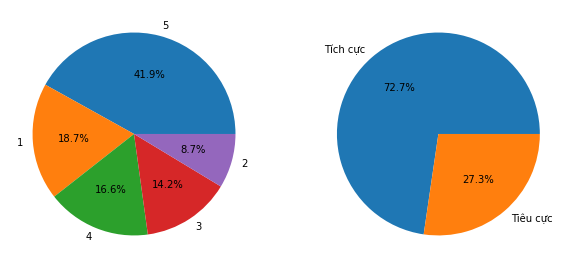

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

#Tỉ lệ comment theo sô sao
labels = df.Star.value_counts().index
sizes = df.Star.value_counts().values
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')

labels = ['Tích cực', 'Tiêu cực']
sizes = df.Sentiment.value_counts().values
ax2.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.show()

Ta thấy mức độ phân bố của comment tích cực là **72.7%** và tiêu cực là **27.3 %**, tỉ lệ gần với **7:3**, tức là **trung bình 1 điện thoại có khoảng 70% là comment tốt, và 30% comment xấu**

==> từ đây ta có thể phỏng đoán được công thức cơ bản để **xác định mẩu điện thoại là đáng mua hay không bằng cách tính tỉ lệ phần trăm comment tốt.**

Để xác định là đáng mua thì sản phẩm phải từ khá trở lên, có nghĩa là hơn trung bình, nên ta cần chọn 1 con số lớn hơn so với trung bình để xác định đúng hơn về sản phẩm được đánh giá, ở đây nhóm chọn **mức kì vọng là 80%**.
- Trên 80%, sản phẩm đáng mua
- Dưới 80%, cần xem xét kỉ

## V. Dự Đoán Dữ Liệu Dựa Trên Quá Trình Học Máy

#### 1. Chia tập dữ liệu

Từ tập dữ liệu gốc ta chia tập dữ liệu thành 2 tập test và train:
- Tập train để huấn luyện model
- Tập test để kiểm tra model sau khi nó đã được train xong

In [10]:
test = df[(df.model == 'Vsmart Joy 3')]
len(test)

613

In [11]:
# tách tập test từ dữ liệu
train = df.drop(test.index, axis=0)

Từ tập dữ liệu train ở trên ta chia thành 2 train và val:
- Tập train là dữ liệu thật sự để huấn luyện model
- Tập val là dữ liệu đóng vai trò test trong quá trình huấn luyện model, nhằm mục đích chọn các siêu tham số phù hợp với dữ liệu

In [12]:
# Convert to X_train, y_train
X_train, X_val, y_train, y_val = train_test_split(train["Text"], train["Sentiment"], test_size=0.2, random_state=42)

#### 2. Tiền xữ lý dữ liệu

* Kiểm tra thông tin của dữ liệu

In [13]:
#xem thông tin data:
df.info()
if df.isnull().values.any() == False:
    print("\n=> Không có ô giá trị nào bị thiếu.")
else:
    print("\n=> Dữ liệu bị thiếu.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18018 entries, 0 to 18017
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   model      18018 non-null  object
 1   Text       18018 non-null  object
 2   Sentiment  18018 non-null  int64 
 3   Star       18018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 563.2+ KB

=> Không có ô giá trị nào bị thiếu.


* Thay đổi giá trị trong dữ liệu

*Sau quá trình nhìn vào dữ liệu thì ta nhận ra dữ liệu đầy đủ, tại đây nếu chỉ để visualize dữ liệu thì có thể dừng.*

*Nhưng ở đây chúng tôi muốn dùng dữ liệu để áp dụng vào mô hình học máy. Với dữ liệu text như Comment thì phải tiến hành chuẩn hoá dữ liệu để tăng khả năng học của mô hình học.*

In [14]:
def standardize_data(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm than, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    # xóa số trong câu
    #row = re.sub(r'[0-9]+', '', row)
    row = row.strip()
    return row

def tokenizer(row):
    return word_tokenize(row, format="text")

In [15]:
%%time
#Thời gian xữ lý khá tốn thời gian: khoảng 1-2 min

#Chuẩn hoá dữ liệu
df["Text"] = df.Text.apply(standardize_data)
df["Text"] = df.Text.apply(tokenizer)
df.head(3)

Wall time: 1min 7s


,model,Text,Sentiment,Star
0,Samsung Galaxy A71,Dùng được 1 tháng thì sạc đến 95 % là không lên nữa Rút sạc ra cắm lại thì 100 % khônng hiểu,0,1
1,Samsung Galaxy A71,Trời_ơi làm_ơn cho đổi máy khác đi mua mấy tháng giờ lỗi phần đánh_thức buồn kg trôi đưa đi kiểm_tra rồi về vẫn bị a71 là vậy sao làm_ơn đôi máy khác đi,0,1
2,Samsung Galaxy A71,Máy mua mới từ tháng 5/2020 Dùng được 3 tháng thì cắm sạc không vào ( điện_thoại không rơi vào nước không để nước vào ) Mang ra bảo_hành thì báo lỗi cá_nhân không được bảo_hành thay mất 800 k,0,1


In [16]:

def embedding(X_train, X_test=None):
    global  emb
    emb = TfidfVectorizer(min_df=5, max_df=0.8, max_features=3000, sublinear_tf=True)
    emb.fit(X_train)
    
    # Save pkl file
    joblib.dump(emb, 'tfidf.pkl')
    X_train = emb.transform(X_train)
    #if X_test:
    X_test = emb.transform(X_test)
    return X_train, X_test


def embedding_(X_train):
    global  emb
    emb = TfidfVectorizer(min_df=5, max_df=0.8, max_features=3000, sublinear_tf=True)
    emb.fit(X_train)
    
    # Save pkl file
    joblib.dump(emb, 'tfi_data.pkl')
    X_train = emb.transform(X_train)
    return X_train

In [17]:
%%time
#Embeding X_train
X_train, X_val = embedding(X_train, X_val)

Wall time: 1.42 s


#### 3. Huấn luyện mô hình học

In [18]:
%%time
# thử nghiệm mô hình với các siêu tham số để tìm ra mô hình tốt nhất
best_C = None
best_gamma = None
best_val = float('inf')
train_scores = []
val_scores = []
C = [0.001, 0.01, 0.1, 1, 3, 5, 10]
G = ['scale', 'auto']

#Train 
for  c in C:
    for gamma in G:
        model = svm.SVC(kernel='rbf', C = c, gamma=gamma)
        model.fit(X_train,y_train)
        train_scores.append(model.score(X_train,y_train))
        val_scores.append(model.score(X_val, y_val))
        if val_scores[-1] == max(val_scores):
            best_C = c
            best_gamma = gamma
            best_val = val_scores[-1]


Wall time: 26min 57s


Text(461.35324675324665, 0.5, 'C')

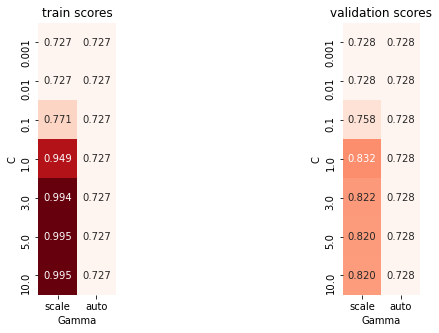

In [19]:
#Trực quan hóa kết quả
train_scores_df = pd.DataFrame(data=np.array(train_scores).reshape(len(C), -1),
                             index=C, columns=G)
val_scores_df = pd.DataFrame(data=np.array(val_scores).reshape(len(C), -1), 
                           index=C, columns=G)
min_score = min(min(train_scores), min(val_scores))
max_score = max(max(train_scores), max(val_scores))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True,
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('train scores'); plt.xlabel('Gamma'); plt.ylabel('C')
plt.subplot(1, 2, 2)
sns.heatmap(val_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True,
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('validation scores'); plt.xlabel('Gamma'); plt.ylabel('C')

Tham số C khi huấn luyện ở tập train sẽ có sự tăng dần khi C tăng dần nhưng tập val sẽ tăng đến 1 ngưỡng r giảm xuống vì khi C càng tăng mô hình càng fit vào dữ liệu train sẽ dẫn đến hiện tượng overfitting làm giảm độ chính xác khi transform tập test

In [20]:
print('Siêu tham số C ta thu được là: ',best_C)
print('Siêu tham số gamma ta thu được là: ', best_gamma)
print('kết quả tốt trên tập val: ', best_val)

Siêu tham số C ta thu được là:  1
Siêu tham số gamma ta thu được là:  scale
kết quả tốt trên tập val:  0.8319448434357943


In [21]:
# Huấn luyện lại mô hình trên toàn bộ tập dữ liệu train
# standardize and tokenizer
train_final = train.Text.apply(standardize_data)
train_final = train.Text.apply(tokenizer)

# Embedding
X_train_final = embedding_(train_final)
y_train_final = train.Sentiment

# train and save model
model = svm.SVC(kernel='rbf', C = best_C, gamma=best_gamma)
model.fit(X_train_final, y_train_final)
joblib.dump(model, 'saved_model.pkl')


['saved_model.pkl']

#### 4. Đánh giá mô hình học

In [24]:
# standardize and tokenizer
test['Text'] = test.Text.apply(standardize_data)
test['Text'] = test.Text.apply(tokenizer)

# Embedding
emb = joblib.load('tfi_data.pkl')
X_test  = emb.transform(test.Text)
y_test = test.Sentiment.values

#  Load weights
model = joblib.load('saved_model.pkl')

#  Result
rc = model.predict(X_test)

In [25]:
print("Tỉ lệ dự đoán chính xác là " ,accuracy_score(y_test, rc))

Tỉ lệ dự đoán chính xác là  0.831973898858075


#### 5. Đánh giá sản phẩm

*Dựa vào phân tích khi trả lời câu hỏi số 3*

Để đánh giá điện thoại là có đáng mua hay không, nhóm đánh giá theo công thức là:

- *Điện thoại đáng mua là điện thoại có tỉ lệ comment tốt trên 80%*

In [26]:
def analyze(result):
    bad = np.count_nonzero(result)
    good = len(result) - bad
    print("Number of bad and neutral comments = ", bad)
    print("Number of good comments = ", good)

    if good/(bad+good) > 0.8:
        print("==> Tốt, sản phẩm đáng mua!")
    else:
        print("==> Tệ, cần được xem xét kĩ trước khi mua!")

In [27]:
analyze(rc)

Number of bad and neutral comments =  457
Number of good comments =  156
==> Tệ, cần được xem xét kĩ trước khi mua!


**Qua kết quả trên ta thấy có 457 comments tốt về sản phẩm, 156 comment xấu. Nên chúng ta cần kiểm tra kĩ trước khi mua nó**

---

## VI. KÌ VỌNG TRONG TƯƠNG LAI

Tập dữ liệu này được crawl từ trang thegioididong.com, nhóm đánh giá các comment trên trang web này là trung thực và không có các comment giả để tăng khả năng bán hàng.

==> Nên khi áp dụng mô hình này vào các comment trên các nền tảng bán hàng online khác như tiki hay lazada thì kết quả sẽ không cho được tỉ lệ dự đoán chính xác vì trên các nên tảng này chứa khá nhiều comment giả để tăng uy tín.

Do đó: **Kì vọng của nhóm là có thể tạo được mô hình học có thể phân biệt comment thật/ comment giả, từ đó có thể áp dụng cho nhiều nền tảng bán hàng.**

---

## VII. NHÌN LẠI QUÁ TRÌNH LÀM ĐỐ ÁN

**Khó khăn:** 

* việc lựa chọn được một dataset phù hợp và đưa ra chủ đề là khá tốn thời gian, chiếm khoảng 2/3 tổng thời gian làm đồ án
* Vì tập data này là khá nhỏ (18018 dòng, 4 cột) nên việc mô hình học đạt tỉ lệ cao trên 90% là khá khó, vì khó khăn áp dụng các thuật toán deep learning

## VIII. TÀI LIỆU THAM KHẢO

1. Tham khảo các tài liệu từ các notebook có sẳn trên [Kaggle](https://www.kaggle.com/)

2. https://gate.ac.uk/sale/nle-svm/svm-ie.pdf

3. http://aurelieherbelot.net/resources/slides/teaching/SVMs.pdf